<h1>
<center>
Analyzing New York City High School Data 
</center>
</h1>

## 1. Available data to analyze New York City high schools

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets. 

We have combined the following data sets into a single pandas data frame : 

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt): Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) : Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a): The percentage of students who graduated, another outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) : Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2010-2011-NYC-School-Survey/mnz3-dyi8): Survey of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. 

## 2. Data pre-processing

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

#### Read in the data

In [2]:
data_files = ["ap_2010.csv", "class_size.csv", "demographics.csv",
             "graduation.csv", "hs_directory.csv", "sat_results.csv"]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

#### Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## 3. What features have the strongest correlations with the SAT score?

In [10]:
correlations = combined.corr()

In [11]:
correlations_sat = correlations["sat_score"]

In [12]:
correlations_sat

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

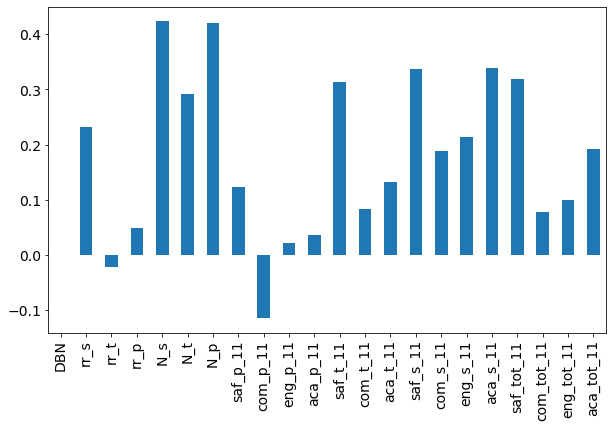

In [13]:
correlations_sat[survey_fields].plot(kind="bar", figsize=(10,6), fontsize=14);

We can consult the data dictionary from the [City of New York's website](https://data.cityofnewyork.us/Education/2010-2011-NYC-School-Survey/mnz3-dyi8) to understand what the survey variable names are.

The 2 variables which are the more correlated are the number of students and the number of teacher respondents. These two variables are correlated with the total enrollment.

The communication score has a negative correlation with the SAT score. We must study how this score is calculated to understand the result. 

It is hard to draw any conclusions when we don't have more information on the data. 

However, we can also notice that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school correlate highly with stat_score. Let's dig into this relationship a bit more and try to figure out which schools have low safety scores.

## 4. Safety and SAT scores

Let's make a scatter plot of the safety and respect score based on parent response and the sat score. 

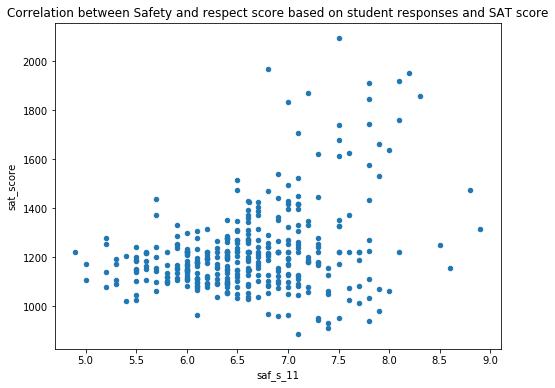

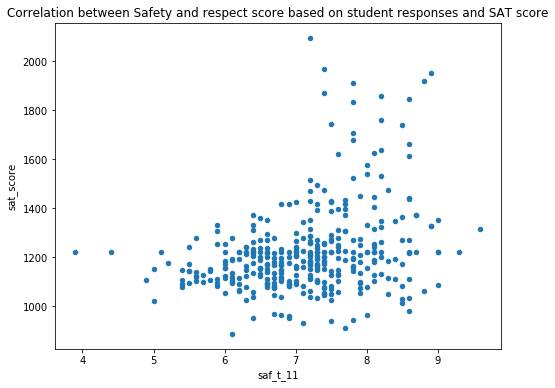

In [14]:
combined.plot(kind="scatter", x="saf_s_11", y="sat_score", figsize=(8,6),
             title="Correlation between Safety and respect score based on student responses and SAT score");
combined.plot(kind="scatter", x="saf_t_11", y="sat_score", figsize=(8,6),
             title="Correlation between Safety and respect score based on student responses and SAT score");

These plots don't help us to see a clear correlation between the safety and SAT scores. We can notice however that high SAT scores only occur with high Safety score. 

Let's map out safety score to understand if the district is related to safety and respect score. 

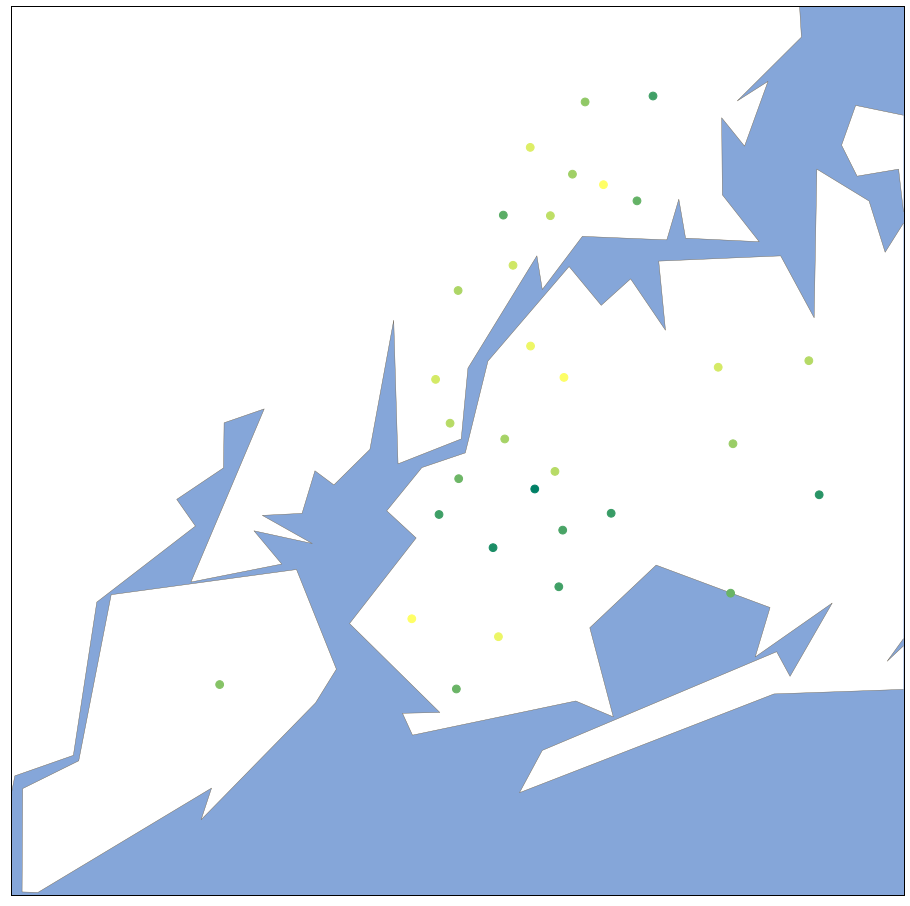

In [15]:
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

plt.figure(figsize=(16,20))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=60, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer");

Upper Manhattan and parts of Queens and the Bronx have lower safety scores, whereas Brooklyn has high safety scores.

### 5. Ethnicity and SAT scores

Let's explore if there is a correlation between race and SAT score. 

In [16]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlation_race = correlations_sat[race_fields]

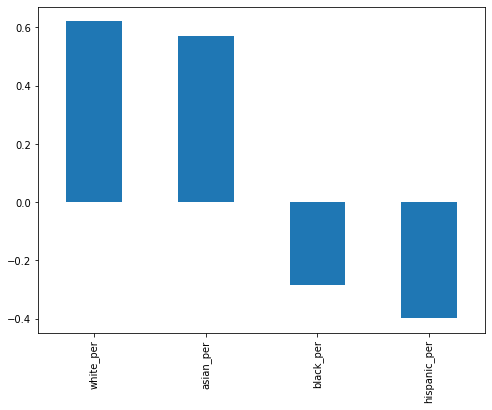

In [17]:
correlation_race.plot(kind="bar", figsize=(8,6));

We can see that white and Asian percentage correlates with the SAT_score. This may be due to a lack of funding for schools in specific areas, which are more likely to have a higher rate of Black or Hispanic students.
It would make more sense to study the fundings of each school and the percent of race in each district rather than the race itself which does not make sense on its own. 

Let's dig into the relationship between  hispanic percent SAT score, even if I don't think it makes sense to correlate a race to a school score...

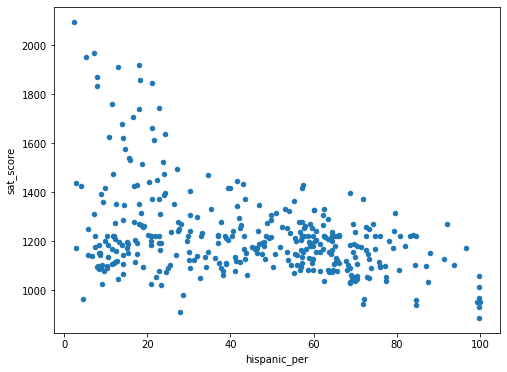

In [18]:
combined.plot(kind="scatter", x="hispanic_per", y="sat_score", figsize=(8,6));

This plot does not show a clear trend between Hispanic percent and sat score. However, we can see that unfortunately, high SAT score only occurs in school with low Hispanic percent and low SAT score just happens in school with high Hispanic percent.

This type of results is the reason why being a data scientist does not only deal with plotting data and playing with it without context. Obviously, the cause of this link between Hispanic percent and SAT score has nothing to do with the Hispanic "race" itself, but with the way they have access to a good education in New York.

Let's find swhool with a percentage of hispanic greater than 95%: 

In [19]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed are offering classes to immigrants recently arrived from Spanish-speaking countries. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

Let's now research any schools with a percent of hispanic less than 10% and an average SAT score greater that 1800

In [20]:
condition = (combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)
combined[condition]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## 6. Gender and SAT scores

In [21]:
gender_fields = ["male_per", "female_per"]
correlation_gender = correlations_sat[gender_fields]

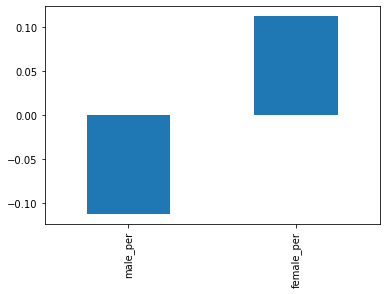

In [22]:
correlation_gender.plot(kind="bar");

We can see that women seem to have a better SAT score than men.
Let's make a scatter plot of the female percent and the sat score.

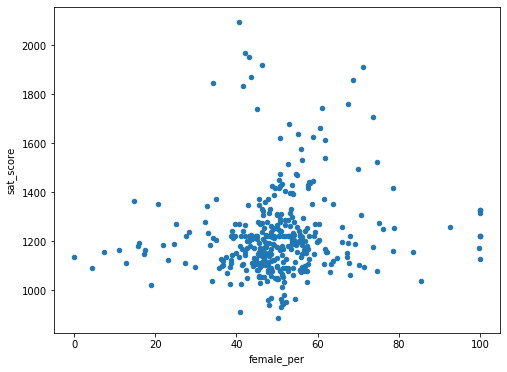

In [23]:
combined.plot(kind="scatter", x="female_per", y="sat_score", figsize=(8,6));

We don't see any correlation. As for the race study, we have to go deeper, because it does not make sense to think that gender has a direct effect on the SAT score.

Let's research any schools with percent of female greater than 60% and an average SAT score greater than 1700:

In [24]:
condition = (combined["female_per"] > 60 ) & (combined["sat_score"] > 1700)
combined[condition]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

## 7. AP scores and SAT scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who tool AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

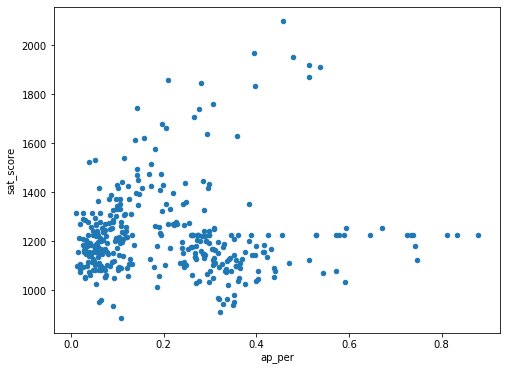

In [25]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x='ap_per', y='sat_score', figsize=(8,6));

We can see that schools with low AP test takers tend to score low on SAT as well. However, schools with high AP test takers generally score higher. 
The correlation is not very clear or very strong, because we can also see a second trend keeping the SAT score around 1200, constant, whatever the AP test taker percent is. 
It could be interesting to see if another parameter is responsible for the switch between the 2 trends. 

## 8. Conclusions

This study was an introduction to NYC high school data. In a complete analysis, we could dig into these potential steps:
- Is there a correlation between class size and SAT score?
- Which neighborhoods have the best schools? If we combine this information with a dataset containing property values, we could find the least expensive areas that have good schools.
- Investigating the differences between parent, teacher and student responses to surveys
- Assigning scores to schools based on sat_score and other attributes like safety and respect.